### Подключение инфраструктуры

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/GU_NN/'

In [0]:
import sys
import os
sys.path.append(PATH)

### Задание

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

### Библиотеки

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf

In [5]:
print(tf.__version__)

2.2.0


### Константы

In [0]:
RANDOM_STATE = 1
NUM_LABELS = 101 # Количество меток класса

In [0]:
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.compat.v1.random.set_random_seed(RANDOM_STATE)

### Загрузка и подготовка датасета LFW

https://tensorflow.google.cn/datasets/catalog/lfw?hl=zh-cn

In [0]:
import tensorflow_datasets as tfds


(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    download=True,
    data_dir= os.path.join(PATH, 'source'),
    as_supervised=True,
    with_info=True,
    split=['train[:80%]','train[:80%]'],
)


In [9]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

### Визуализация датасета LFW

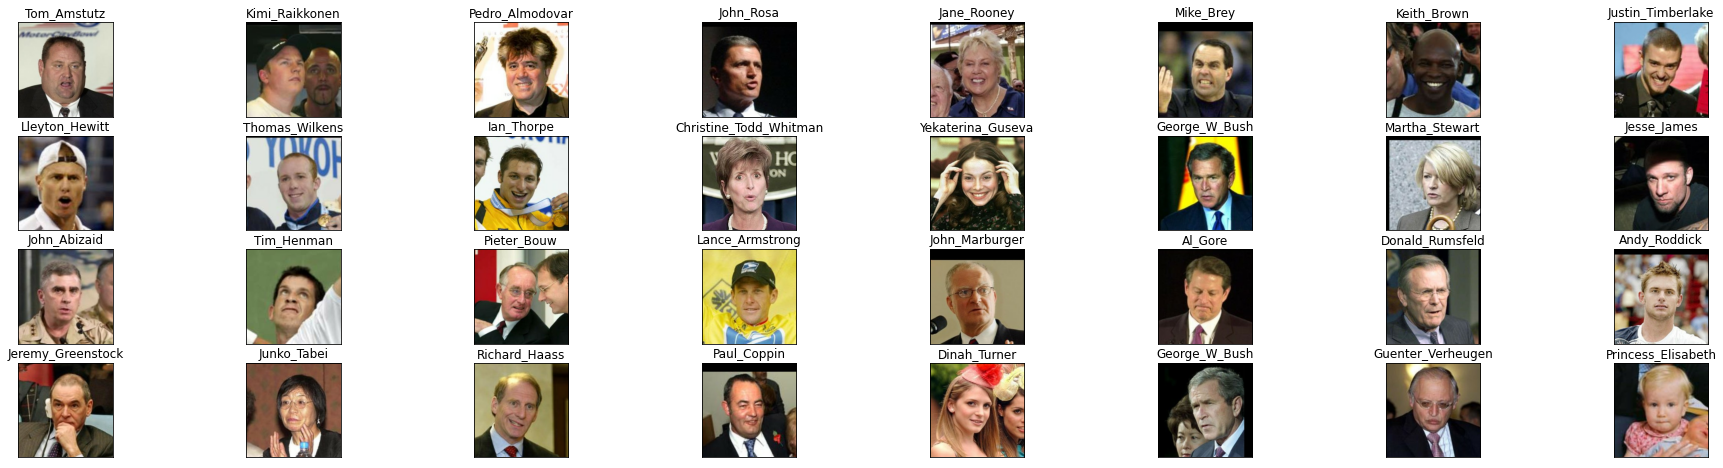

In [10]:
fig = plt.figure(figsize=(32, 8))
for i, data in enumerate(iter(test_ds.take(32))):
    label, image = data
    ax = fig.add_subplot(4, 8, i+1)
    ax.imshow(image[:,:])
    ax.set_title(label.numpy().decode('utf-8'))
    plt.xticks([]), plt.yticks([])
    i += 1
plt.show()


### Создание модели CNN

In [0]:
input_shape=(250, 250, 3)
EMB_SIZE = 64

left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)

convnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
embedding = tf.concat([encoded_l, encoded_r], axis=0)

model = tf.keras.Model([left_input,right_input],embedding)

### Contrastive Loss

In [0]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1, labels2 = labels   

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)


## Подготовка пайплайна данных

In [0]:
BATCH_SIZE = 64*2
NUM_EPOCHS = 10
BUFFER_SIZE = tf.data.experimental.cardinality(train_ds)

train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
try:
  model.load_weights(os.path.join(PATH, 'training', 'siamese_net.weight'))
except:
  pass

### Обучение модели

In [15]:
%%time
if 0:
  for iteration, (labels1, images1) in enumerate(train_ds):
      # Forward
      with tf.GradientTape() as tape:
          img1 = np.array(images1).astype(np.float32) / 255.
          bs = img1.shape[0]
          img1, img2 = img1[:bs//2, :], img1[bs//2:, :]
          labels1, labels2 = labels1[:bs//2], labels1[bs//2:]
          embs = model([img1, img2])
          loss_value = contastive_loss(embs, (labels1, labels2))
                
      # Backward
      grads = tape.gradient(loss_value, model.variables)

      optimizer.apply_gradients(zip(grads, model.variables))

      if iteration % 200 == 0:
        model.save_weights(os.path.join(PATH, 'training',  'siamese_net.weight'))
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


### Проверка на тестовой выборке

In [0]:
count_row = 4
count_column = 8
test_ds = test_ds.batch(count_row*count_column)
iteration, (labels, images)= next(enumerate(test_ds.take(1)))

In [17]:
labels

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Tom_Amstutz', b'Kimi_Raikkonen', b'Pedro_Almodovar',
       b'John_Rosa', b'Jane_Rooney', b'Mike_Brey', b'Keith_Brown',
       b'Justin_Timberlake', b'Lleyton_Hewitt', b'Thomas_Wilkens',
       b'Ian_Thorpe', b'Christine_Todd_Whitman', b'Yekaterina_Guseva',
       b'George_W_Bush', b'Martha_Stewart', b'Jesse_James',
       b'John_Abizaid', b'Tim_Henman', b'Pieter_Bouw', b'Lance_Armstrong',
       b'John_Marburger', b'Al_Gore', b'Donald_Rumsfeld', b'Andy_Roddick',
       b'Jeremy_Greenstock', b'Junko_Tabei', b'Richard_Haass',
       b'Paul_Coppin', b'Dinah_Turner', b'George_W_Bush',
       b'Guenter_Verheugen', b'Princess_Elisabeth'], dtype=object)>

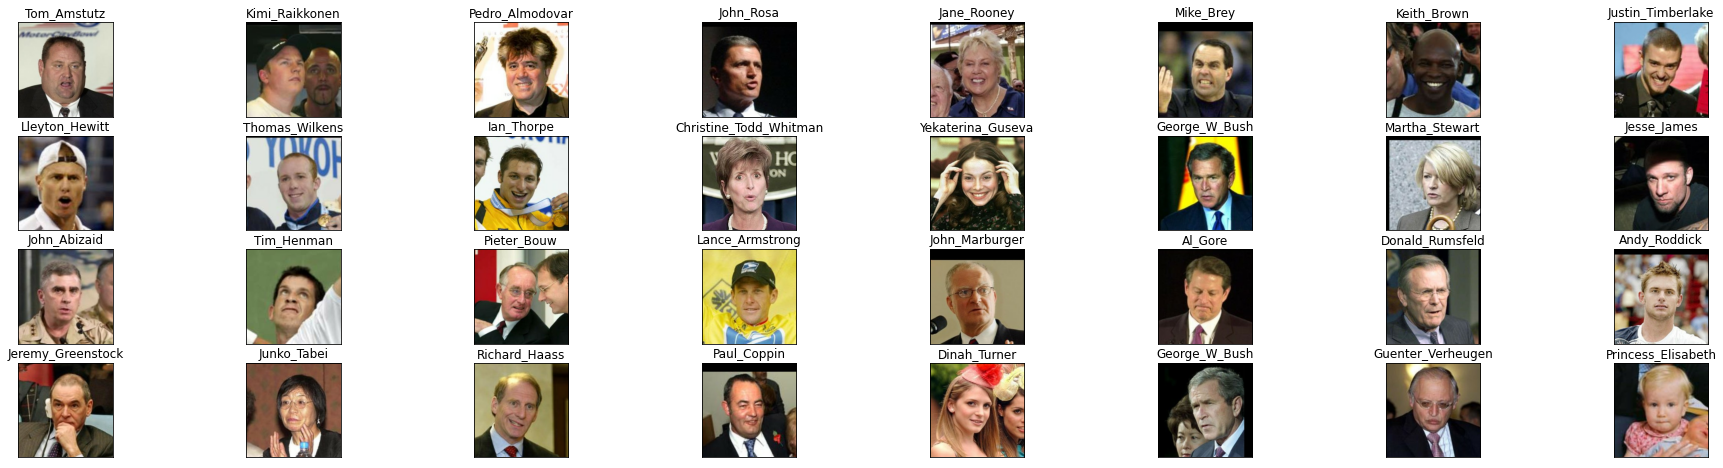

In [18]:
fig = plt.figure(figsize=(32, 8))

for i in range(count_row*count_column):
    ax = fig.add_subplot(count_row, count_column, i+1)
    ax.imshow(images[i])
    ax.set_title(labels[i].numpy().decode('utf-8'))
    plt.xticks([]), plt.yticks([])
    i += 1
plt.show()

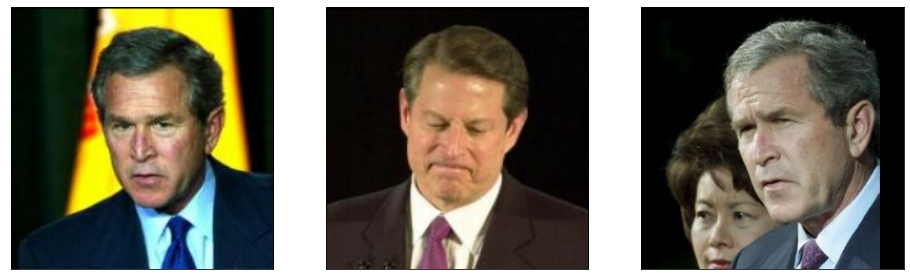

In [66]:
some_samples = [images[13,:], images[21,:], images[29,:]]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(1, 3, j+1)
    ax.imshow(np.squeeze(some_samples[j]), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
new_embs = model([np.stack((images[13,:], images[13,:]), axis=0), np.stack((images[21,:], images[29,:]), axis=0)])

In [68]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

print('A1 <-> A1: ', diff(emb1, emb2))
print('A1 <-> B1: ', diff(emb1, emb3))
print('A1 <-> A2: ', diff(emb1, emb4))


A1 <-> A1:  0.0
A1 <-> B1:  1819.473962440793
A1 <-> A2:  1175.2628961215444
